# EDA: Digging into the Frequency and Severity of the dataset


## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Load the data

In [3]:
motor_df = pd.read_csv('../../data/input/exp/Motor_vehicle_insurance_data.csv', delimiter=";")
claims_df = pd.read_csv('../../data/input/exp/sample_type_claim.csv', delimiter=';')


## 1. Claims Frequency Distribution

| Column | Description |
|--------|-------------|
| Number | Categorical group for number of claims ranging from 0 to 25 (maximum number of claims made by 1 policyholder) |
| Policies | Number of unique policies per group |
| Claims | Total number of claims per group |
| Proportion | Ratio of each group's policies to total number of policies |

### 1.1 Define the binning function

In [ ]:
def assign_claims_bin(claims_value):
    if claims_value <= 25:
        return str(claims_value)
    else:
        return '25+'

### 1.2 Assign bin to each row

In [ ]:
motor_df['claim_bin'] = motor_df['N_claims_year'].apply(assign_claims_bin)

### 1.3 Create a unique policy id to differentiate each policy/row

In [ ]:
motor_df['unique_policy_id'] = motor_df['ID'].astype(str) + motor_df['Date_last_renewal'].astype(str) + motor_df['Date_next_renewal'].astype(str)

### 1.4 Group by claim bin and aggregate

In [ ]:
grouping = (
    motor_df
    .groupby('claim_bin', observed=True)
    .agg({'unique_policy_id': 'nunique', 'N_claims_year': 'sum'})
    .rename(columns={'unique_policy_id': 'Policies', 'N_claims_year': 'Claims'})
    .sort_values(by=['claim_bin'], key=lambda x: x.astype(int), ascending=True) #using key to convert the values from string to int
    .reset_index()
    .rename(columns={'claims_bin': 'claim_group'})
)

### 1.5 Calculate proportion

In [ ]:
grouping['Proportion'] = (grouping['Policies'] / grouping['Policies'].sum()).round(4)

### 1.6 Append summary row

In [ ]:
length_of_grouping = len(grouping)
grouping.loc[length_of_grouping] = ['Sum', grouping['Policies'].sum(), grouping['Claims'].sum(), grouping['Proportion'].sum()]

### 1.7 Transpose for presentation

In [ ]:
grouping_transposed  = grouping.T
grouping_transposed
grouping_transposed.columns = [''] * len(grouping_transposed.columns)
grouping_transposed

---
## 2. Claims Severity Distribution

| Metric | Description |
|--------|-------------|
| Cost_claims_year | Average severity (loss cost) made by each policyholder that initiated claims |

*Note: Visual inspection uses logarithmic scale to reveal distribution shape*

### 2.1 Summary statistics

In [18]:
claims_summary  =  (
    claims_df[['Cost_claims_year']].drop_duplicates(keep='first') ### Sample df already aggregated the loss cost to each policyholder just need to drop duplicates
    .describe()
    .drop('count')
    .T
    .reset_index(drop=True)
)
claims_summary

,mean,std,min,25%,50%,75%,max
0,1041.265623,4930.436935,40.05,150.4,337.67,758.33,236285.18


### 2.2 Distribution plots (raw vs log scale)

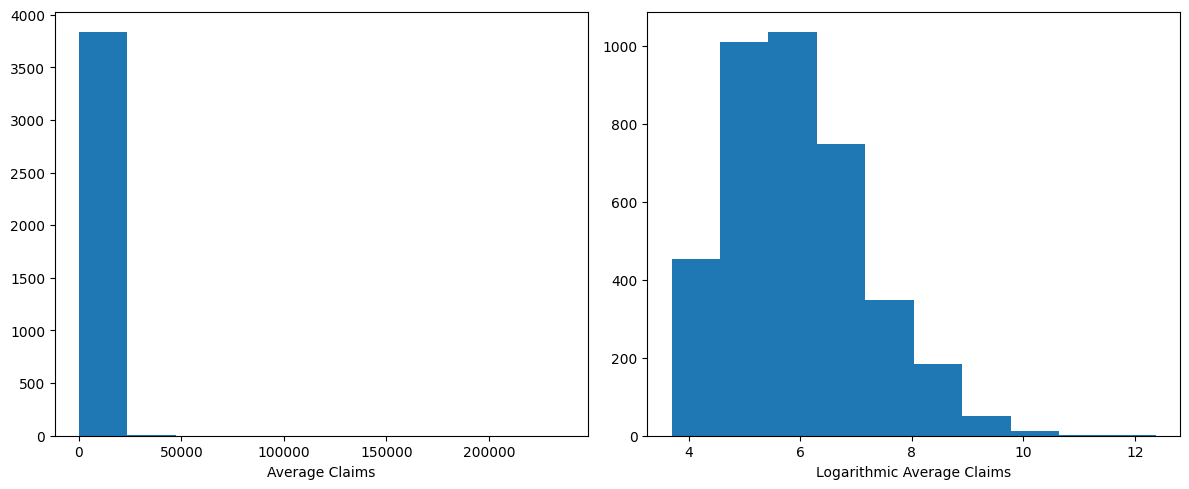

In [23]:
claims  = claims_df[['Cost_claims_year']].drop_duplicates(keep='first')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

fig, ax1.hist(claims['Cost_claims_year'])
ax1.set_xlabel("Average Claims")
ax1.set_title("")

# Histogram of log(yAvg)
ax2.hist(np.log(claims['Cost_claims_year']))
ax2.set_xlabel("Logarithmic Average Claims")
ax2.set_title("")

plt.tight_layout()
plt.show()